# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.440376,True,3.951884
1,0.829566,True,3.104935
2,-1.568506,False,-0.397000
3,-2.619818,False,-2.346435
4,-1.047487,False,-1.182153
...,...,...,...
995,-1.998157,False,-1.661160
996,-2.030133,False,1.531485
997,-2.202204,False,-0.282965
998,-0.890898,True,4.048622


<Axes: xlabel='v0'>

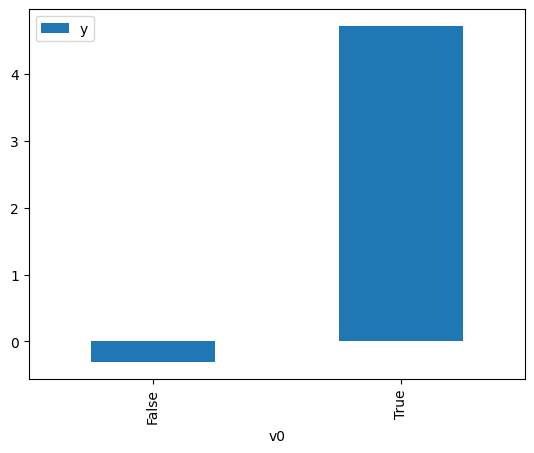

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

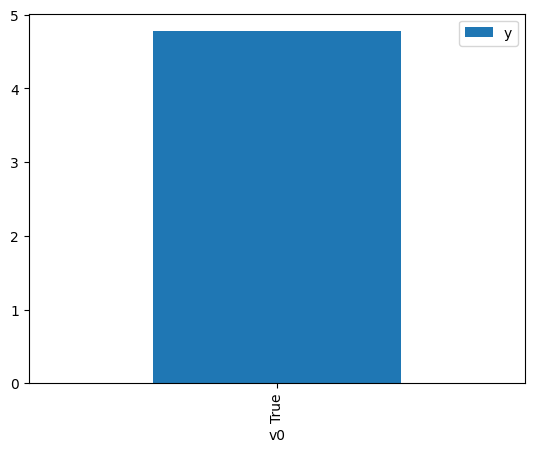

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.862186,False,0.434291,0.798731,1.251987
1,-1.325959,False,0.646164,0.892379,1.120600
2,-0.180181,False,-2.025783,0.573153,1.744735
3,-1.440122,False,-2.667253,0.908601,1.100593
4,-0.866316,False,-1.232885,0.799783,1.250339
...,...,...,...,...,...
995,-1.121367,False,-0.030175,0.856951,1.166927
996,1.209559,False,0.899246,0.128593,7.776474
997,-0.449938,False,-0.188308,0.673344,1.485124
998,-0.510354,False,0.133479,0.694098,1.440719


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.096993,True,5.861459,0.459452,2.176507
1,-1.721505,True,5.361476,0.060440,16.545435
2,0.490274,True,5.158979,0.683644,1.462749
3,-0.890898,True,4.048622,0.194035,5.153704
4,0.757345,True,4.857702,0.767621,1.302726
...,...,...,...,...,...
995,-0.511832,True,4.275136,0.305404,3.274352
996,-1.546743,True,4.520745,0.078270,12.776254
997,-1.095718,True,3.017324,0.148117,6.751399
998,-0.777090,True,3.648378,0.223885,4.466577


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.887
Model:                            OLS   Adj. R-squared (uncentered):              0.887
Method:                 Least Squares   F-statistic:                              3917.
Date:                Fri, 19 Jan 2024   Prob (F-statistic):                        0.00
Time:                        13:26:03   Log-Likelihood:                         -1410.1
No. Observations:                1000   AIC:                                      2824.
Df Residuals:                     998   BIC:                                      2834.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3838      0.024     15.710      0.000       0.336       0.432
x2             5.0430      0.058     86.996      0.000       4.929       5.157
==============================================================================
Omnibus:                        1.579   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.523
Skew:                          -0.021   Prob(JB):                        0.467
Kurtosis:                       2.813   Cond. No.                         2.37
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""